In [1]:
%load_ext rpy2.ipython

import pandas as pd
from metasub_utils.packet_parse import MetaSUBTableFactory
from capalyzer.packet_parser.experimental import umap
import warnings

warnings.filterwarnings('ignore')

core_tabler = MetaSUBTableFactory.core_factory()

/home/dcdanko/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
%%R

library(ggthemes)
library(ggplot2)
library(reshape2)
library(gridExtra)
library(ALDEx2)
library(RColorBrewer)

In [5]:
mdata = core_tabler.metadata
mdata.columns

def asfloat(val):
    try:
        return float(val)
    except ValueError:
        return float('nan')

qc_mdata = mdata[['num_reads', 'library_post_PCR_Qubit', 'library_QC_concentration',]]
qc_mdata = qc_mdata.dropna(how='all')
qc_mdata['library_post_PCR_Qubit'] = [asfloat(el) for el in qc_mdata['library_post_PCR_Qubit']]
qc_mdata['library_QC_concentration'] = [asfloat(el) for el in qc_mdata['library_QC_concentration']]
qc_mdata.shape

(3692, 3)

In [6]:
taxa = core_tabler.taxonomy(normalize=True)
taxa_rho = taxa.corrwith(qc_mdata['library_QC_concentration'], axis=0, method='spearman')
taxa_qc = pd.concat([taxa.mean(), taxa_rho], axis=1)
taxa_qc = taxa_qc.rename(columns={0: 'mean_abund', 1: 'rho'})
taxa_qc.head()

,mean_abund,rho
Enterobacter sp. FY-07,0.000055,0.096913
Enterobacter sp. R4-368,0.000045,0.130232
Enterobacter sp. 638,0.000078,0.026831
Enterobacter sp. CRENT-193,0.000007,0.148227
Enterobacter sp. E20,0.000030,0.043959


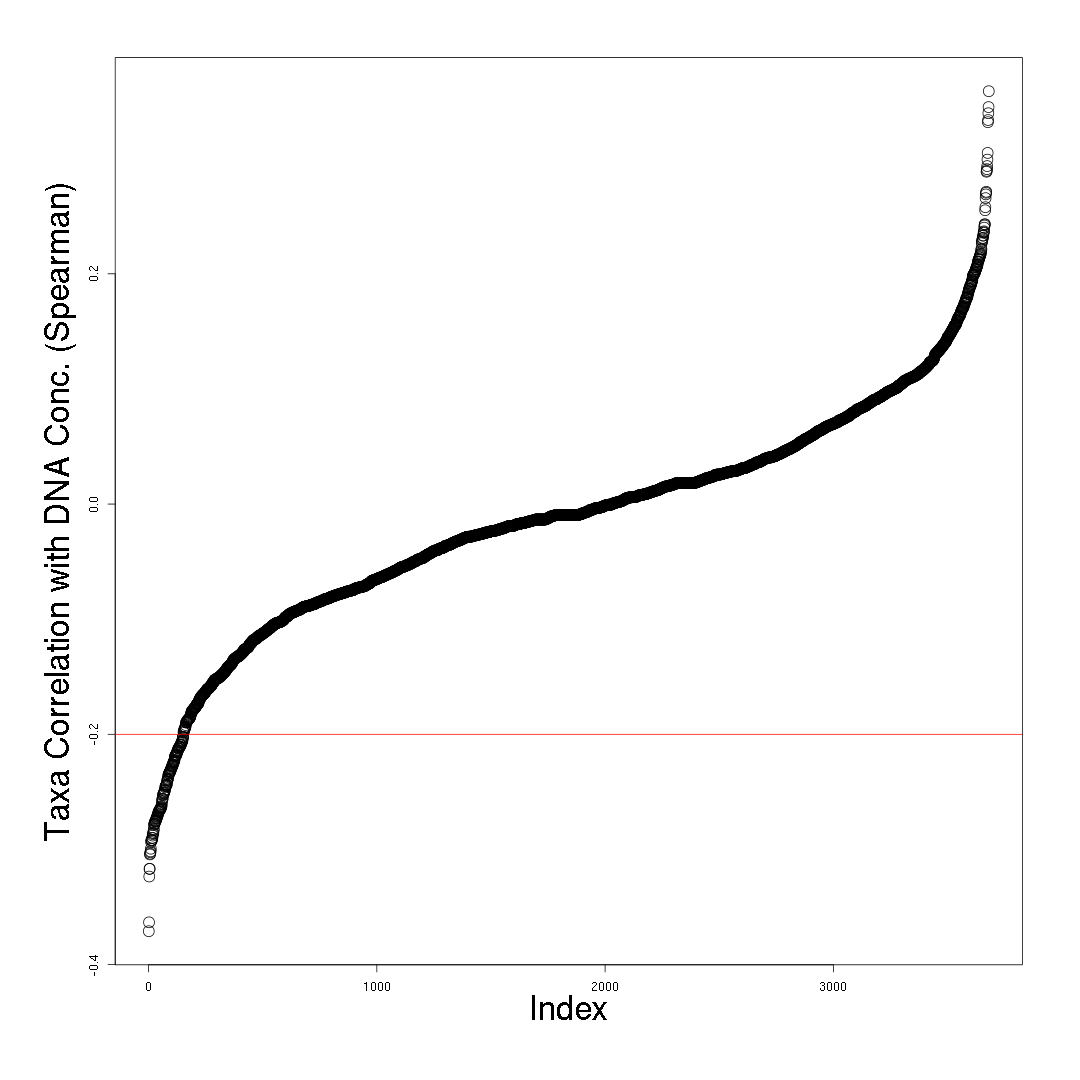

In [7]:
%%R -i taxa_rho -w 1080 -h 1080

par(mar=c(8, 8, 4, 4))
plot(sort(taxa_rho), ylab='Taxa Correlation with DNA Conc. (Spearman)', cex.lab=3, cex=2)
abline(h=-0.2, col='red')

In [29]:
import numpy as np

rands = pd.DataFrame(np.random.rand(taxa.shape[0], taxa.shape[1]), columns=taxa.columns, index=taxa.index)
rands = (rands.T / rands.sum(axis=1)).T
rands_rho = rands.corrwith(qc_mdata['library_QC_concentration'], axis=0, method='spearman')

rands.sum(axis=1).head()

haib18CEM5453_HMGW3CCXY_SL342284    1.0
haib17CEM5106_HCCGHCCXY_SL270581    1.0
haib17CEM5106_HCY5HCCXY_SL270948    1.0
haib18CEM5453_HT5YVCCXY_SL357318    1.0
haib18CEM5453_HNHKFCCXY_SL346090    1.0
dtype: float64

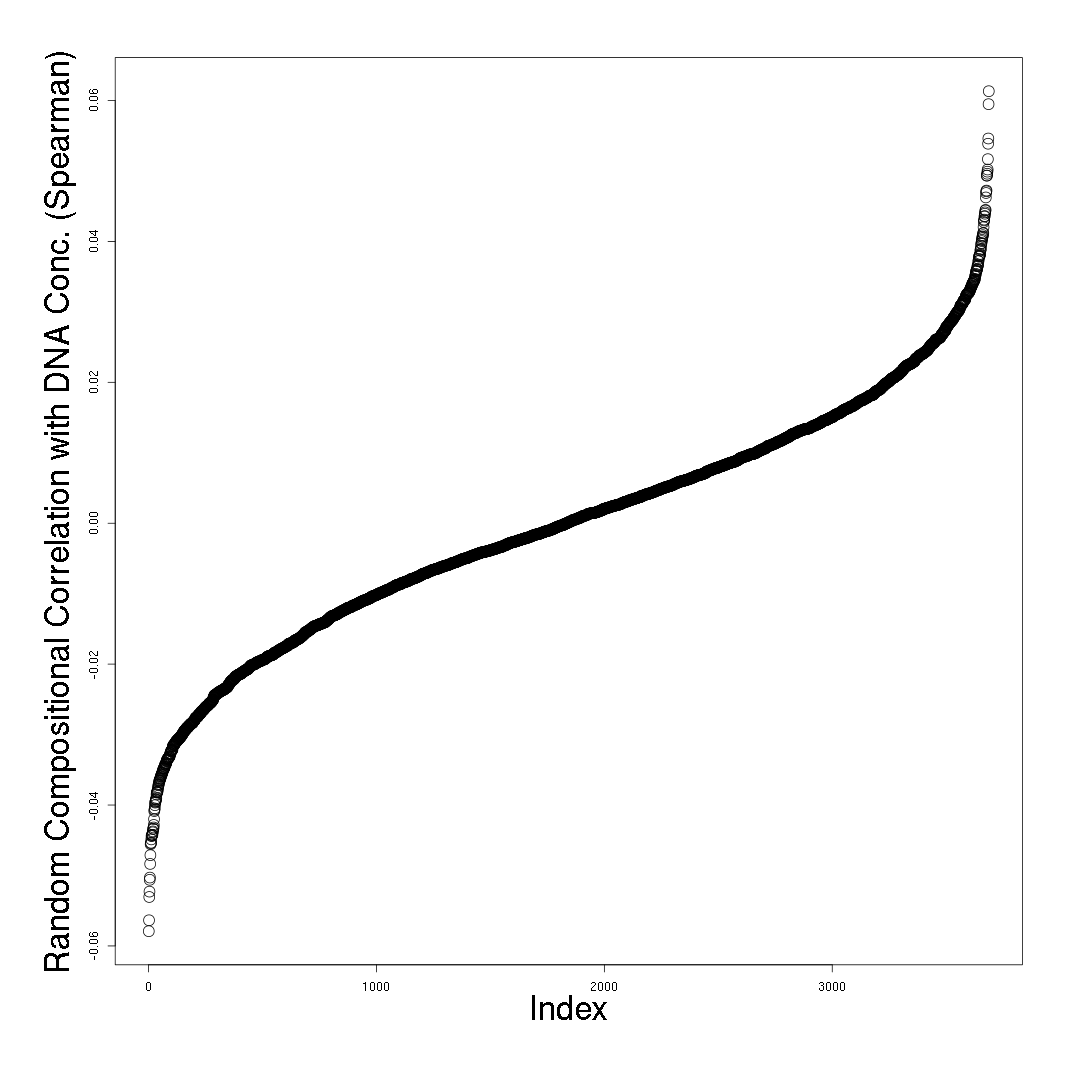

In [30]:
%%R -i rands_rho -w 1080 -h 1080

par(mar=c(8, 8, 4, 4))
plot(sort(rands_rho), ylab='Random Compositional Correlation with DNA Conc. (Spearman)', cex.lab=3, cex=2)
abline(h=-0.2, col='red')

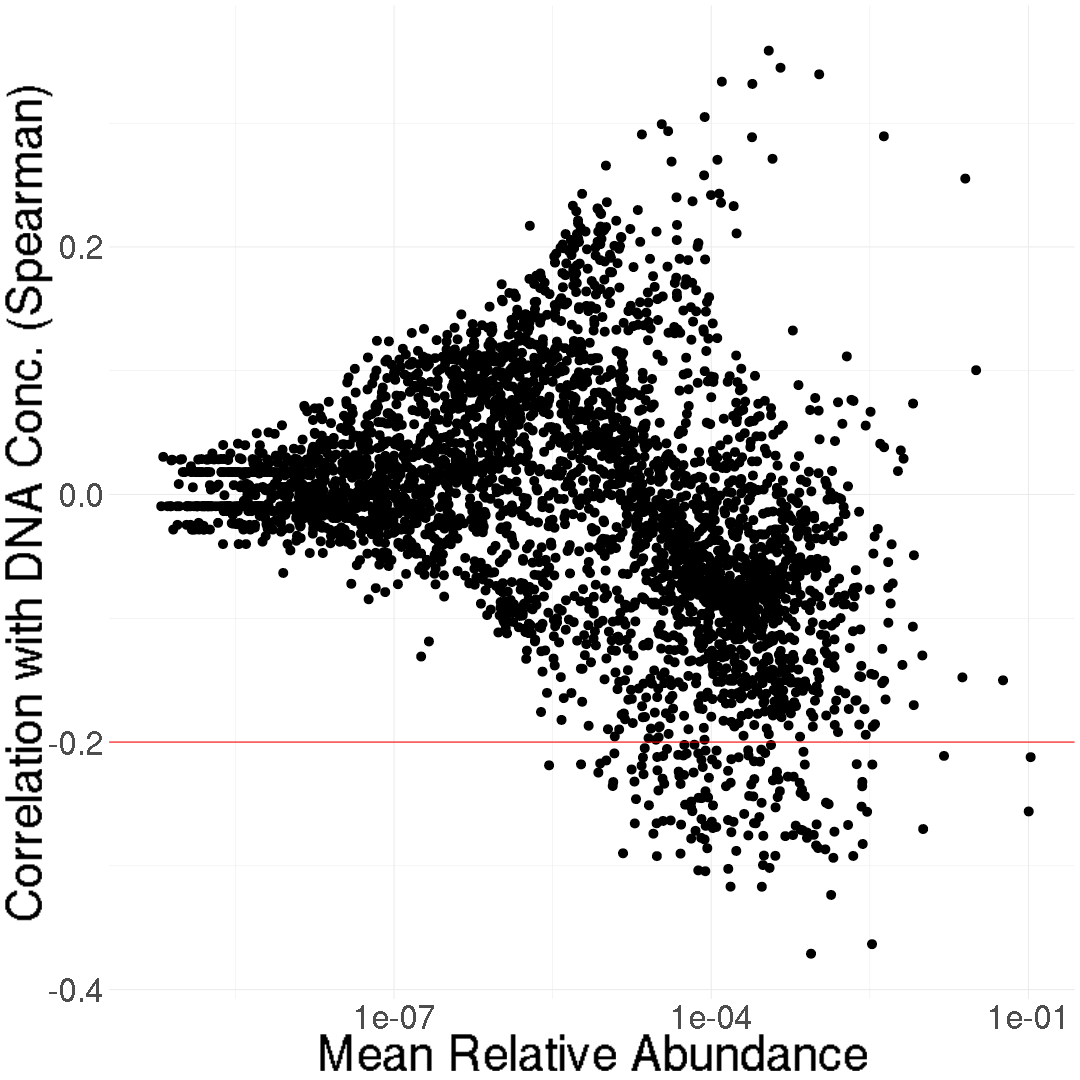

In [8]:
%%R -i taxa_qc -w 1080 -h 1080


ggplot(taxa_qc, aes(x=mean_abund, y=rho)) +
    geom_point(size=4) +
    theme_minimal() +
    ylab('Correlation with DNA Conc. (Spearman)') +
    xlab('Mean Relative Abundance') +
    scale_x_log10() +
    #scale_y_log10() +
    geom_hline(yintercept=-0.2, col='red') +
    theme(
        text = element_text(size=50),
        legend.position='right',
    )

In [9]:
bad_taxa = taxa_rho[taxa_rho < -0.2].index
bad_taxa = list(bad_taxa)

bad_genus = set([''.join(el.split()[0]) for el in bad_taxa])
print(len(bad_genus))
print(len(bad_taxa))

neg_taxa = set(['Salmonella enterica', 'Escherichia coli', 'Serratia marcescens',
       'Pseudomonas stutzeri', 'Pseudomonas aeruginosa', 'Pseudomonas putida',
       'Pseudomonas fluorescens', 'Stenotrophomonas sp. LM091',
       'Stenotrophomonas maltophilia', 'Bradyrhizobium sp. SK17',
       'Bradyrhizobium sp. BTAi1', 'Bradyrhizobium diazoefficiens',
       'Bradyrhizobium japonicum', 'Bradyrhizobium sp.',
       'Bradyrhizobium sp. CCGE-LA001', 'Bradyrhizobium sp. S23321',
       'Rhodopseudomonas palustris', 'Methylobacterium populi',
       'Ochrobactrum anthropi', 'Ochrobactrum sp. A44',
       'Ochrobactrum pseudogrignonense', 'Brevundimonas naejangsanensis',
       'Brevundimonas sp. DS20', 'Altererythrobacter marensis',
       'Achromobacter xylosoxidans', 'Janthinobacterium sp. 1_2014MBL_MicDiv',
       'Janthinobacterium svalbardensis', 'Janthinobacterium sp. LM6',
       'Cupriavidus metallidurans', 'Ralstonia pickettii', 'Bacillus subtilis',
       'Staphylococcus aureus', 'Staphylococcus hominis',
       'Staphylococcus epidermidis', 'Staphylococcus capitis',
       'Staphylococcus haemolyticus', 'Staphylococcus lugdunensis',
       'Listeria monocytogenes', 'Enterococcus faecium',
       'Enterococcus faecalis', 'Lactobacillus fermentum',
       'Streptococcus thermophilus', 'Lactococcus lactis',
       'Leuconostoc mesenteroides', 'Negativicoccus massiliensis',
       'Kocuria rhizophila', 'Micrococcus luteus', 'Rothia dentocariosa',
       'Microbacterium sp. PAMC 28756', 'Microbacterium sp. TPU 3598',
       'Janibacter indicus', 'Dermacoccus nishinomiyaensis',
       'Brevibacterium linens', 'Corynebacterium variabile',
       'Corynebacterium efficiens', 'Rhodococcus fascians',
       'Rhodococcus sp. PBTS 2', 'Rhodococcus erythropolis',
       'Cutibacterium acnes', 'Saccharomyces cerevisiae',
       'Enterococcus phage EF62phi'])
neg_taxa & set(bad_taxa)

61
152


{'Cutibacterium acnes',
 'Negativicoccus massiliensis',
 'Pseudomonas fluorescens',
 'Rothia dentocariosa',
 'Staphylococcus capitis',
 'Streptococcus thermophilus'}

In [10]:
from scipy.stats import pearsonr

taxa_pearson = taxa.corrwith(qc_mdata['library_QC_concentration'], axis=0, method=pearsonr)
taxa_pearson = pd.DataFrame(taxa_pearson.tolist())
taxa_pearson = taxa_pearson.rename(columns={0: 'r', 1: 'p'})
taxa_qc2 = pd.concat([taxa_qc, taxa_pearson], axis=1)
taxa_pearson.head()


,r,p
0,0.291655,6.248094e-69
1,0.277835,1.818278e-62
2,0.138021,3.299812e-16
3,0.167365,3.416459e-23
4,0.141132,6.965531e-17


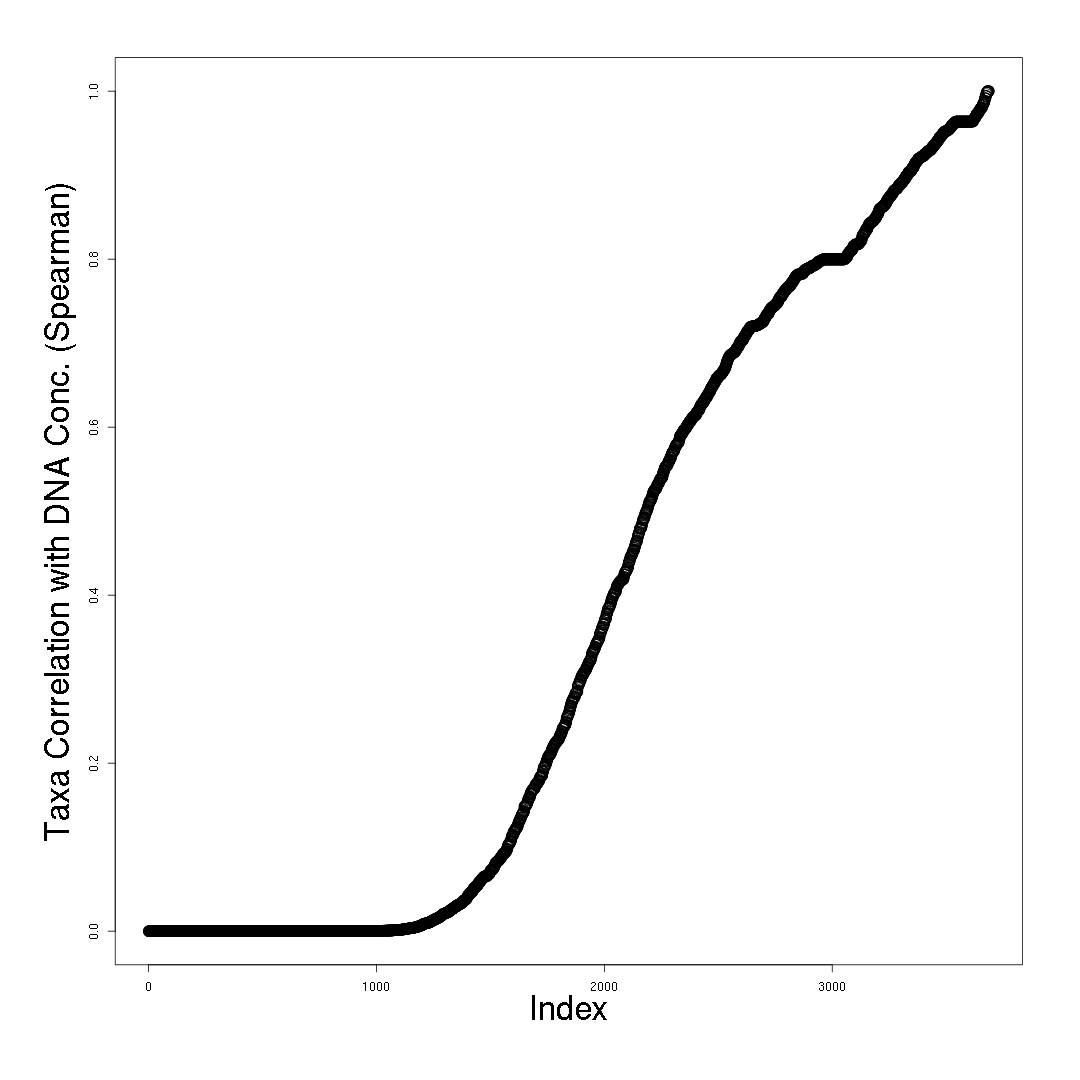

In [11]:
%%R -i taxa_qc2 -w 1080 -h 1080

par(mar=c(8, 8, 4, 4))
plot(sort(taxa_qc2$p), ylab='Taxa Correlation with DNA Conc. (Spearman)', cex.lab=3, cex=2)
abline(h=-0.2, col='red')

In [22]:

def iscontrol(el):
    if el == 0:
        return 'Grey'
    if el in ['ctrl cities']:
        return 'Blue'
    if el in ['positive_control', 'poszymo']:
        return 'Green'
    if el in ['negative_control', 'dry tube', 'dry tube & swab', 'tube & rna/dna out', 'tube & rna/dna out & swab']:
        return 'Red'
    return 'Grey'



contams = core_tabler.csv_in_dir('other/probable_contamination_homology.csv')
control_type = core_tabler.metadata.loc[contams.index, 'control_type'].apply(iscontrol)
print(sum(control_type=='Grey'))
print(contams.shape)
contams.head()

137
(190, 31)


,Cutibacterium,Pseudomonas,Salmonella,Escherichia,Lactobacillus,Salmonella enterica,Staphylococcus,Bacillus,Enterobacteria,Pseudomonas aeruginosa,...,Bradyrhizobium,Devosia,Xanthobacter autotrophicus,Cupriavidus,Cupriavidus metallidurans,Alicycliphilus denitrificans,Achromobacter,Bradyrhizobium oligotrophicum,bacterium,Homo
haib18CEM5453_HNHKFCCXY_SL345511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
haib17CEM5106_HCY5HCCXY_SL270943,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
haib17CEM5106_HCY5HCCXY_SL270995,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
haib18CEM5453_HNHKFCCXY_SL345601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
haib18CEM5453_HNHKFCCXY_SL345572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


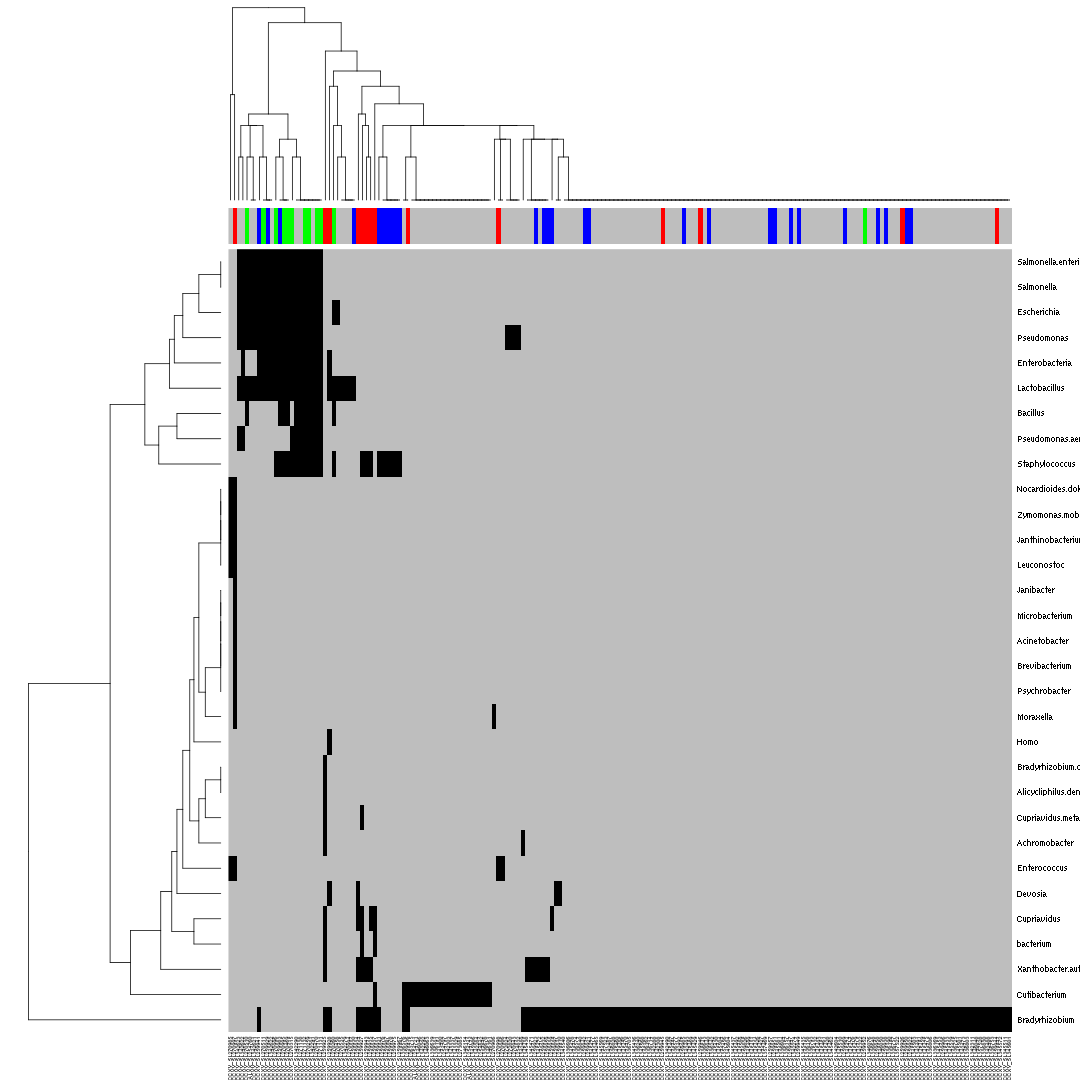

In [20]:
%%R -i contams -i control_type -w 1080 -h 1080

heatmap(t(as.matrix(contams)), scale='none', ColSideColors=control_type, col=c('grey', 'black'))

In [23]:
contams.columns

Index(['Cutibacterium', 'Pseudomonas', 'Salmonella', 'Escherichia',
       'Lactobacillus', 'Salmonella enterica', 'Staphylococcus', 'Bacillus',
       'Enterobacteria', 'Pseudomonas aeruginosa', 'Moraxella',
       'Zymomonas mobilis', 'Nocardioides dokdonensis', 'Enterococcus',
       'Janthinobacterium', 'Leuconostoc', 'Microbacterium', 'Janibacter',
       'Acinetobacter', 'Brevibacterium', 'Psychrobacter', 'Bradyrhizobium',
       'Devosia', 'Xanthobacter autotrophicus', 'Cupriavidus',
       'Cupriavidus metallidurans', 'Alicycliphilus denitrificans',
       'Achromobacter', 'Bradyrhizobium oligotrophicum', 'bacterium', 'Homo'],
      dtype='object')